In [1]:
import pandas as pd
import numpy as np

from src.utils import save_submission
from src.utils import postprocess
from src.metrics import novametric
from hyperopt import hp, tpe, fmin

import lightgbm
import lightgbm as lgb

from src.preprocess import static_augment

from sklearn import set_config

set_config(transform_output="pandas")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 200)

%load_ext autoreload
%autoreload 2

session_performance_log = []


## Data


In [2]:
df = pd.read_parquet("../data/raw/train_data.parquet")
submission_data = pd.read_parquet("../data/raw/submission_data.parquet")


## Preprocessing

In [3]:
full_df = pd.concat([df, submission_data], axis=0)

preprocessing_params = {
    "date_features": True,
    "laggings": True,
    "monthly_lag": True,
    "simple_categorial_facts": True,
    "fix_dayweek_count": True,
    "phase_country_stats": True,
    "phase_dayweek_stats": True,
    "phase_wd_stats": True,
    "phase_brand_stats": False,
    "phase_bcm_stats": True,
    "phase_brand_month_stats": False,
    "phase_country_month_stats": True,
    "phase_wd_month_stats": True,
    "gamma_features": False,
    "gamma_log_features": False,
    "norm_features": True,
    "norm_log_features": False,
}

full_df["phase"] = np.log1p(full_df["phase"])
full_df["monthly"] = np.log1p(full_df["monthly"])

full_processed_df = static_augment(
    full_df,
    **preprocessing_params,
)

full_processed_df.sample(5)


,brand,phase,country,dayweek,month,wd_perc,ther_area,hospital_rate,n_nwd_bef,n_nwd_aft,date,wd,wd_left,monthly,main_channel,year,quarter,day,weekday,week,is_weekend,weekday_sin,weekday_cos,month_sin,month_cos,week_sin,week_cos,day_sin,day_cos,phase_1,phase_2,phase_3,n_nwd_bef_1,n_nwd_aft_1,phase_wd_1,n_nwd_bef_2,n_nwd_aft_2,phase_wd_2,n_nwd_bef_3,n_nwd_aft_3,phase_wd_3,phase_month_mean_1,phase_month_median_1,phase_month_std_1,phase_month_min_1,phase_month_max_1,phase_month_mean_2,phase_month_median_2,phase_month_std_2,phase_month_min_2,phase_month_max_2,phase_month_mean_3,phase_month_median_3,phase_month_std_3,phase_month_min_3,phase_month_max_3,phase_week_mean_1,phase_week_median_1,phase_week_std_1,phase_week_min_1,phase_week_max_1,phase_week_mean_2,phase_week_median_2,phase_week_std_2,phase_week_min_2,phase_week_max_2,phase_week_mean_3,phase_week_median_3,phase_week_std_3,phase_week_min_3,phase_week_max_3,phase_wd_mean_diff_1,phase_wd_median_diff_1,phase_day_mean_diff_1,phase_day_median_diff_1,phase_wd_mean_diff_week_1,phase_wd_median_diff_week_1,phase_day_mean_diff_week_1,phase_day_median_diff_week_1,phase_wd_mean_diff_2,phase_wd_median_diff_2,phase_day_mean_diff_2,phase_day_median_diff_2,phase_wd_mean_diff_week_2,phase_wd_median_diff_week_2,phase_day_mean_diff_week_2,phase_day_median_diff_week_2,phase_wd_mean_diff_3,phase_wd_median_diff_3,phase_day_mean_diff_3,phase_day_median_diff_3,phase_wd_mean_diff_week_3,phase_wd_median_diff_week_3,phase_day_mean_diff_week_3,phase_day_median_diff_week_3,phase_bcm_mean,phase_bcm_std,phase_bcm_max,phase_bcm_median,phase_bcm_count,phase_wd_month_mean,phase_wd_month_std,phase_wd_month_max,phase_wd_month_median,phase_wd_month_count,phase_country_mean,phase_country_std,phase_country_max,phase_country_median,phase_country_count,phase_dayweek_mean,phase_dayweek_std,phase_dayweek_max,phase_dayweek_median,phase_dayweek_count,phase_wd_mean,phase_wd_std,phase_wd_max,phase_wd_median,phase_wd_count,phase_country_month_mean,phase_country_month_std,phase_country_month_max,phase_country_month_median,phase_country_month_count,country_nunique_brands,brand_nunique_countries,brand_nunique_years,country_main_channel_COMBINED,country_main_channel_HOSPITAL,country_main_channel_OTHERS,country_main_channel_RETAIL,monthly_lag,dayweek_0,dayweek_1,dayweek_2,dayweek_3,dayweek_4,dayweek_5,dayweek_6,alpha_norm_no_log,beta_norm_no_log
113970,VDVBR,0.042983,Aldovia,2.0,5,0.909091,L,0.498412,0.0,0.0,2019-05-29,20,2,0.058530,RETAIL,2019,2,29,2,22,0,0.974928,-0.222521,5.000000e-01,-0.866025,0.464723,-0.885456,-0.394356,0.918958,NaN,NaN,NaN,0.0,1.0,0.060406,0.0,0.0,0.052963,2.0,0.0,0.127617,0.046201,0.051582,0.025921,0.0,0.104399,0.044269,0.045649,0.019532,0.0,0.092508,0.04605,0.036817,0.031213,0.0,0.127617,0.030131,0.030060,0.024997,0.000000,0.060406,0.027806,0.030455,0.026581,0.000000,0.052963,0.063808,0.063808,0.090239,0.0,0.127617,0.014205,0.008823,NaN,NaN,0.030274,0.030346,NaN,NaN,0.008694,0.007314,NaN,NaN,0.025157,0.022508,NaN,NaN,0.081567,0.090799,NaN,NaN,0.063808,0.063808,NaN,NaN,0.046167,0.026581,0.127617,0.043078,126.0,0.037541,0.051009,0.430257,0.019006,5197.0,0.046942,0.038440,0.276863,0.039443,86227.0,0.048140,0.050741,0.573052,0.036975,382986.0,0.039438,0.052479,0.573052,0.023089,72654.0,0.045821,0.037751,0.230891,0.038181,7556.0,110,30,10,0,33930,0,85152,0.068813,4.0,4.0,5.0,5.0,5.0,0.0,4.0,0.048128,0.031674
2527263,BZJGB,0.063250,Westeros,2.0,6,1.000000,NaN,NaN,0.0,4.0,2013-06-26,20,0,0.006450,NaN,2013,2,26,2,26,0,0.974928,-0.222521,1.224647e-16,-1.000000,-0.0,-1.0,-0.848644,0.528964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,3,2,0,44443,0,38284,NaN,4.0,4.0,4.0,4.0,4.

In [4]:
len(full_processed_df.columns)


142

## Modeling

In [5]:
train_df = full_processed_df[full_processed_df["date"] < "2022-01-01"].copy()

min_date = train_df["date"].min()

errors = []

model_params = {
    "n_estimators": 300,
    "colsample_bytree": 0.85,
    "learning_rate": 0.05,
    "min_child_samples": 80,
    "num_leaves": 100,
    "reg_alpha": 3,
    "reg_lambda": 1,
    "subsample": 0.8,
}

# Cross validation
for cutoff_date in [
    "2019",
    "2020",
    "2021",
]:
    eval_start_date = pd.to_datetime(cutoff_date)
    eval_end_date = eval_start_date + pd.DateOffset(years=1)

    print(f"Training since {min_date} until {eval_start_date}")

    X_train = train_df[train_df["date"] < eval_start_date].drop(
        columns=["monthly", "phase", "date"]
    )
    y_train = train_df[train_df["date"] < eval_start_date]["phase"]

    validation_mask = (train_df["date"] >= eval_start_date) & (
        train_df["date"] < eval_end_date
    )

    X_val = train_df[validation_mask].drop(columns=["monthly", "phase", "date"])
    y_val = train_df[validation_mask]["phase"]

    clf = lgb.LGBMRegressor(
        **model_params,  # type: ignore
        random_state=42,
        force_row_wise=True,
        first_metric_only=True,
        n_jobs=-1,
        verbose=0,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_names=["X_val", "y_val"],
        eval_metric="rmse",
        callbacks=[
            lightgbm.early_stopping(25),
        ],
    )

    print(f"Evaluating since {eval_start_date} until {eval_end_date}")
    X_pred = train_df[validation_mask].copy()
    X_pred["prediction"] = clf.predict(X_val)

    X_pred = postprocess(
        X_pred,
        zero_threshold=0.0,
        absolute_minimum=False,
        min_max_scale=False,
        # train_data=train_df[train_df["date"] < eval_start_date],
    )

    error = novametric(X_pred)

    print("Performance:", error * 1000)

    errors.append(error)

session_performance_log.append(
    {
        "timestamp": pd.Timestamp.now(),
        "error_mean": np.mean(errors) * 1000,
        "error_std": np.std(errors) * 1000,
        "preprocessing_params": preprocessing_params,
        "model_params": model_params,
        "errors": errors,
    }
)

print("-----------------------------------")
print("Average Performance:", np.mean(errors) * 1000)
print("Standard Deviation:", np.std(errors) * 1000)
print("-----------------------------------")


Training since 2013-01-01 00:00:00 until 2019-01-01 00:00:00
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[293]	X_val's rmse: 0.0494778	X_val's l2: 0.00244805
Evaluating since 2019-01-01 00:00:00 until 2020-01-01 00:00:00
Performance: 8.182649999999999
Training since 2013-01-01 00:00:00 until 2020-01-01 00:00:00
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[299]	X_val's rmse: 0.0496981	X_val's l2: 0.0024699
Evaluating since 2020-01-01 00:00:00 until 2021-01-01 00:00:00
Performance: 8.39001
Training since 2013-01-01 00:00:00 until 2021-01-01 00:00:00
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[295]	X_val's rmse: 0.0477839	X_val's l2: 0.0022833
Evaluating since 2021-01-01 00:00:00 until 2022-01-01 00:00:00
Performance: 8.11879
-----------------------------------
Average Performance: 8.230483333333

In [6]:
pd.DataFrame(session_performance_log).sort_values("timestamp", ascending=False)


,timestamp,error_mean,error_std,preprocessing_params,model_params,errors
0,2023-11-27 08:19:17.933905,8.230483,0.115776,"{'date_features': True, 'laggings': True, 'monthly_lag': True, 'simple_categorial_facts': True, 'fix_dayweek_count': True, 'phase_country_stats': True, 'phase_dayweek_stats': True, 'phase_wd_stats': True, 'phase_brand_stats': False, 'phase_bcm_stats': True, 'phase_brand_month_stats': False, 'phase_country_month_stats': True, 'phase_wd_month_stats': True, 'gamma_features': False, 'gamma_log_features': False, 'norm_features': True, 'norm_log_features': False}","{'n_estimators': 300, 'colsample_bytree': 0.85, 'learning_rate': 0.05, 'min_child_samples': 80, 'num_leaves': 100, 'reg_alpha': 3, 'reg_lambda': 1, 'subsample': 0.8}","[0.00818265, 0.00839001, 0.00811879]"


In [7]:
latest_error = session_performance_log[-1]
print("Average Performance:", latest_error["error_mean"])
print("Standard Deviation:", latest_error["error_std"])


Average Performance: 8.230483333333334
Standard Deviation: 0.1157759126742497


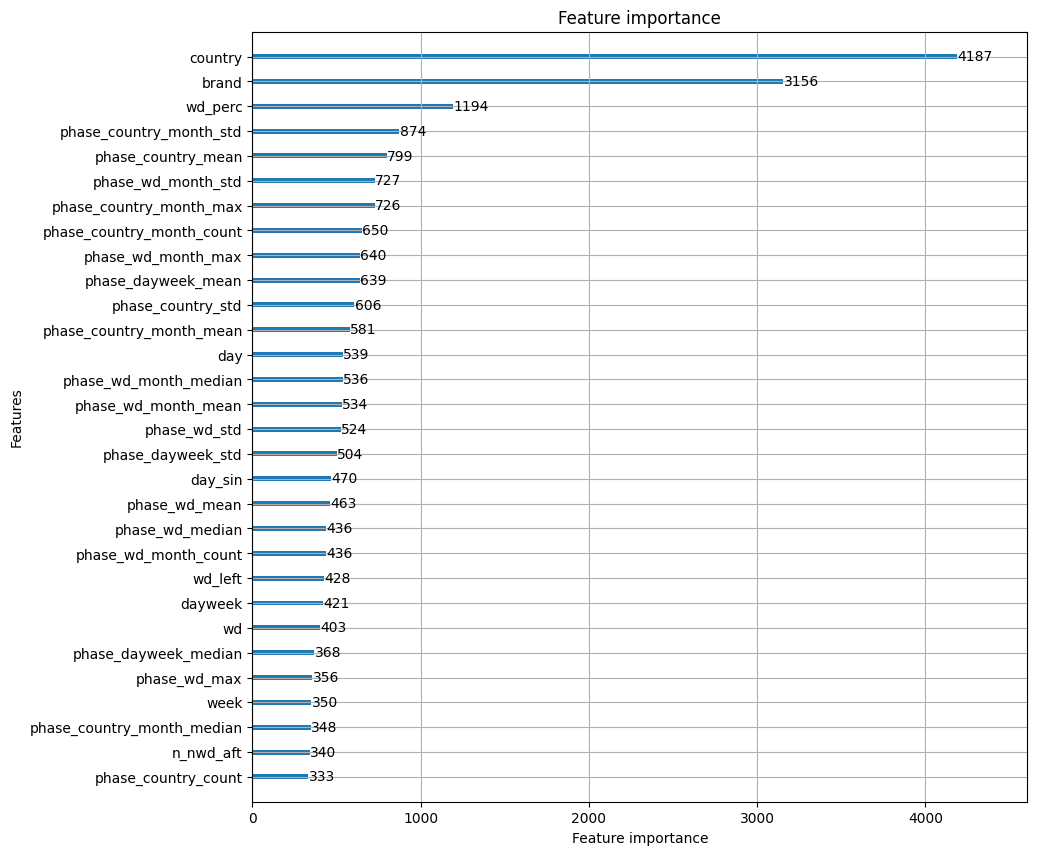

In [8]:
_ = lgb.plot_importance(clf, max_num_features=30, figsize=(10, 10))


### Hyperparameter Tuning

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
valgrid = {
    "num_leaves": hp.quniform("num_leaves", 20, 200, 10),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "n_estimators": hp.quniform("n_estimators", 300, 8000, 100),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "subsample": hp.quniform("subsample", 0.5, 1.0, 0.1),
    "min_child_samples": hp.quniform("min_child_samples", 20, 100, 20),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
    "reg_alpha": hp.choice(
        "reg_alpha", [0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 10.0]
    ),
    "reg_lambda": hp.choice(
        "reg_lambda", [0.01, 0.05, 0.1, 0.2, 0.4, 1.0, 2.0, 4.0, 10.0]
    ),
}


def objective(params):
    train_df = full_processed_df[full_processed_df["date"] < "2022-01-01"].copy()

    errors = []

    model_params = {
        "n_estimators": int(params["n_estimators"]),
        "num_leaves": int(params["num_leaves"]),
        "learning_rate": params["learning_rate"],
        "subsample": params["subsample"],
        "min_child_samples": int(params["min_child_samples"]),
        "colsample_bytree": params["colsample_bytree"],
        "reg_alpha": params["reg_alpha"],
        "reg_lambda": params["reg_lambda"],
    }

    for cutoff_date in ["2021"]:
        eval_start_date = pd.to_datetime(cutoff_date)
        eval_end_date = eval_start_date + pd.DateOffset(years=1)

        print("Training with params:")
        print(model_params)

        X_train = train_df[train_df["date"] < eval_start_date].drop(
            columns=["monthly", "phase", "date"]
        )
        y_train = train_df[train_df["date"] < eval_start_date]["phase"]

        validation_mask = (train_df["date"] >= eval_start_date) & (
            train_df["date"] < eval_end_date
        )

        X_val = train_df[validation_mask].drop(columns=["monthly", "phase", "date"])

        clf = lgb.LGBMRegressor(
            **model_params,  # type: ignore
            random_state=42,
            force_row_wise=True,
            first_metric_only=True,
            n_jobs=-1,
            verbose=0,
        )

        clf.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_names=["X_val", "y_val"],
            eval_metric="rmse",
            callbacks=[
                lightgbm.early_stopping(30),
            ],
        )

        X_pred = train_df[validation_mask].copy()
        X_pred["prediction"] = clf.predict(X_val)

        X_pred = postprocess(
            X_pred,
            train_data=train_df[train_df["date"] < eval_start_date],
        )

        error = novametric(X_pred)
        errors.append(error)

    session_performance_log.append(
        {
            "timestamp": pd.Timestamp.now(),
            "error_mean": np.mean(errors) * 1000,
            "error_std": np.std(errors) * 1000,
            "preprocessing": preprocessing_params,
            "model_params": model_params,
            "errors": errors,
        }
    )

    print("Average Performance:", np.mean(errors) * 1000)
    print("Standard Deviation:", np.std(errors) * 1000)
    print("-----------------------------------")

    return np.mean(errors) * 1000


best_params: dict = fmin(
    fn=objective,
    space=valgrid,
    max_evals=5,
    algo=tpe.suggest,
)  # type: ignore


### Final Model

In [ ]:
train_df = full_processed_df[full_processed_df["date"] < "2022-01-01"].copy()

clf = lgb.LGBMRegressor(
    n_estimators=int(best_params["n_estimators"]),
    num_leaves=int(best_params["num_leaves"]),
    learning_rate=best_params["learning_rate"],
    subsample=best_params["subsample"],
    min_child_samples=int(best_params["min_child_samples"]),
    colsample_bytree=best_params["colsample_bytree"],
    reg_alpha=best_params["reg_alpha"],
    reg_lambda=best_params["reg_lambda"],
    random_state=42,
    force_row_wise=True,
    n_jobs=-1,
)

X_all_train = train_df[train_df["date"] < "2022-01-01"].drop(
    columns=["monthly", "phase", "date"]
)
y_all_train = train_df[train_df["date"] < "2022-01-01"]["phase"]

clf.fit(
    X_all_train,
    y_all_train,
    eval_set=[(X_all_train, y_all_train)],
    eval_names=["X_all_train", "y_all_train"],
    eval_metric="rmse",
)


## Submission

In [ ]:
pred_df = full_processed_df[full_processed_df["date"] >= "2022-01-01"].copy()

X_pred = pred_df.drop(columns=["monthly", "date", "phase"])

pred_df["prediction"] = clf.predict(X_pred)


pred_df = postprocess(
    pred_df,
    zero_threshold=0.0,
    train_data=train_df[train_df["date"] < "2022-01-01"],
)

save_submission(
    pred_df[["country", "brand", "date", "prediction"]],
    name="lgbm_final",
    p=latest_error["error_mean"],
)


'daeived_lgbm_tuned_2023-11-25-18-58-13_6.66666.csv'